## Problem:

- In out problem, need to detect the nearest pedestrian road to see if the car is violating or not 
- need to know which part is the pedestrian road and which part is the car road  

In [1]:
import os
import sys
import cv2
import time
import mmcv
import torch
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path

repo_path = Path(".").absolute().parent

if os.system == "nt":
    data_path = Path("D:\Datas\parking_violation")
else:
    data_path = repo_path.parent / "data" / "parking_violation"
# pkg_path = repo_path.parent / "PINet_new"
sys.path.append(str(repo_path))
# sys.path.append(str(pkg_path))

In [2]:
video_path = str(data_path / "sample1.mp4")
video = mmcv.VideoReader(video_path)

# obtain basic information
print(len(video))
print(video.width, video.height, video.resolution, video.fps)

# iterate over all frames
for frame in video:
    print(frame.shape)
    break

# read the next frame
img = video.read()

# read a frame by index
img = video[100]

3622
1280 720 (1280, 720) 29.97002997002997
(720, 1280, 3)


In [3]:
import mmseg
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
print(mmseg.__version__)

0.9.0


In [4]:
config_path = repo_path.parent / "mmsegmentation" / "configs" / "resnest"
checkpoint_path = repo_path.parent / "data" / "mmseg" / "checkpoints"
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True)

In [9]:
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x1024_80k_cityscapes/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth -P ~/code/data/mmseg/checkpoints/

--2020-12-29 13:50:36--  https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x1024_80k_cityscapes/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265945854 (254M) [application/octet-stream]
Saving to: ‘/home/simonjisu/code/data/mmseg/checkpoints/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth’

deeplabv3plus_s101- 100%[===================>] 253.62M  8.74MB/s    in 30s     

2020-12-29 13:51:07 (8.55 MB/s) - ‘/home/simonjisu/code/data/mmseg/checkpoints/deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth’ saved [265945854/265945854]



In [5]:
config_file = str(config_path / "deeplabv3plus_s101-d8_512x1024_80k_cityscapes.py")
checkpoint_file = str(checkpoint_path / "deeplabv3plus_s101-d8_512x1024_80k_cityscapes_20200807_144429-1239eb43.pth")

In [6]:
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [8]:
from utils import imsaver, correct_rgb

In [11]:
img = correct_rgb(video[100])
img_path = "./imgs/test_seg.png"
imsaver(img, img_path)

In [21]:
result = inference_segmentor(model, img)

In [ ]:
def process(video):
    for frame in video

In [ ]:
for frame in video:
    print(frame.shape)
    break

In [ ]:
video_path = str(data_path / "sample_video1.mp4")
output_path = str(data_path / "video_output.mp4")
clip1 = VideoFileClip(video_path)
white_clip = clip1.fl_image(pipeline.process) 
%time white_clip.write_videofile(output_path, audio = False)

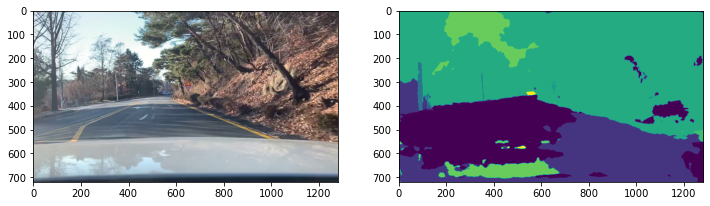

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(img)
axes[1].imshow(result[0])

In [ ]:
cap = cv2.VideoCapture("D:\Datas\parking_violation/sample2.mp4")
while(cap.isOpened()):
    ret, frame = cap.read()
    torch.cuda.synchronize()
    prevTime = time.time()
    frame = cv2.resize(frame, (512,256))/255.0
    frame = np.rollaxis(frame, axis=2, start=0)
    _, _, ti = test(lane_agent, np.array([frame])) 
    curTime = time.time()
    sec = curTime - prevTime
    fps = 1/(sec)
    s = "FPS : "+ str(fps)
    ti[0] = cv2.resize(ti[0], (1280,800))
    cv2.putText(ti[0], s, (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0))
    cv2.imshow('frame', ti[0])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
img = (images[0].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
img, fp, fn = dataloader.dataset.draw_annotation(idx, img=img, pred=prediction[0])
if self.view == 'mistakes' and fp == 0 and fn == 0:
    continue
cv2.imshow('pred', img)
cv2.waitKey(0)